In [1]:
!pip install segmentation-models albumentations

  Using cached segmentation_models-1.0.1-py3-none-any.whl (33 kB)
     |████████████████████████████████| 102 kB 2.6 MB/s eta 0:00:01
  Using cached Keras_Applications-1.0.8-py3-none-any.whl (50 kB)
  Using cached image_classifiers-1.0.0-py3-none-any.whl (19 kB)
  Using cached efficientnet-1.0.0-py3-none-any.whl (17 kB)


In [2]:
%load_ext autoreload
%autoreload 2

# include include folder
import sys
sys.path.append("./miniaturautonomie_lanedetection/include/")
sys.path.append("./include/")

from tensorflow.keras.models import load_model, Model
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import numpy as np
import os
import fnmatch
import random
import cv2
import json

import supervisely_parser as svp
import grid_parser as gp
import render
from DataGenerator import DataGenerator

import albumentations as Alb

In [10]:
annotation_path = './annotation_v3.0/'
image_path = './data/'
packages = ['knuff_main1', 'knuff_main2', 'knuff_main3', 'knuff_hill', 'uni', 'highway', 'knuff_main5', 'knuff_main6']

model_path = './model/ld_autosys.h5'

input_img_size = (480, 640)

number_classes = 7 # outer, middle_curb, guide_lane, solid_lane, hold_line, zebra, background
output_width = 640 
output_height = 224 
input_width = 640 
input_height = 224

val_size = 0.2 # percentage
augmentation = True

batch_size = 16
epochs = 5

transform = Alb.Compose([
    Alb.ShiftScaleRotate(p=0.2),
    Alb.RandomContrast(p=0.4),
    Alb.RandomBrightness(limit=[-0.4,0.2], p=0.4)
])

params = {
    'batch_size': batch_size,
    'input_img_size': input_img_size,
    'target_img_size': (output_height, output_width),
    'shuffle': True,
    'n_channels': number_classes,
    'transform': transform,
    'augmentation': augmentation
}

#################################################################
# run only if to rerender all masks or new packages are added
#render.render_packages(packages, annotation_path, input_img_size)
#################################################################

# generate absolute list of all img and masks paths
image_paths = []
mask_paths = []
# for package
for index in range(len(packages)):
    image_base_path = f"{image_path}{packages[index]}/"
    masks_base_path = f"{annotation_path}{packages[index]}/masks/"

    file_list = os.listdir(masks_base_path)
    pattern = '*.png'
    for filename in file_list:
        if fnmatch.fnmatch(filename, pattern):
            mask_paths.append(os.path.join(masks_base_path, filename))
            image_name = filename[:len(filename)-3]+"jpg"
            image_paths.append(os.path.join(image_base_path, image_name))

# split into train and val set
size_all = len(image_paths)
val_samples = int(size_all*val_size)
random.Random(size_all).shuffle(image_paths)
random.Random(size_all).shuffle(mask_paths)

train_input_img_paths = image_paths[:-val_samples]
train_target_mask_paths = mask_paths[:-val_samples]
val_input_img_paths = image_paths[-val_samples:]
val_target_mask_paths = mask_paths[-val_samples:]

print(f"Len train img: {len(train_input_img_paths)} len train mask: {len(train_target_mask_paths)}")
print(f"Len val img: {len(val_input_img_paths)} len val mask: {len(val_target_mask_paths)}")

# Generators
train_gen = DataGenerator(train_input_img_paths, train_target_mask_paths, **params)
val_gen = DataGenerator(val_input_img_paths, val_target_mask_paths, **params)

    

Len train img: 608 len train mask: 608
Len val img: 152 len val mask: 152


whole batch took: 209.32364463806152ms
16


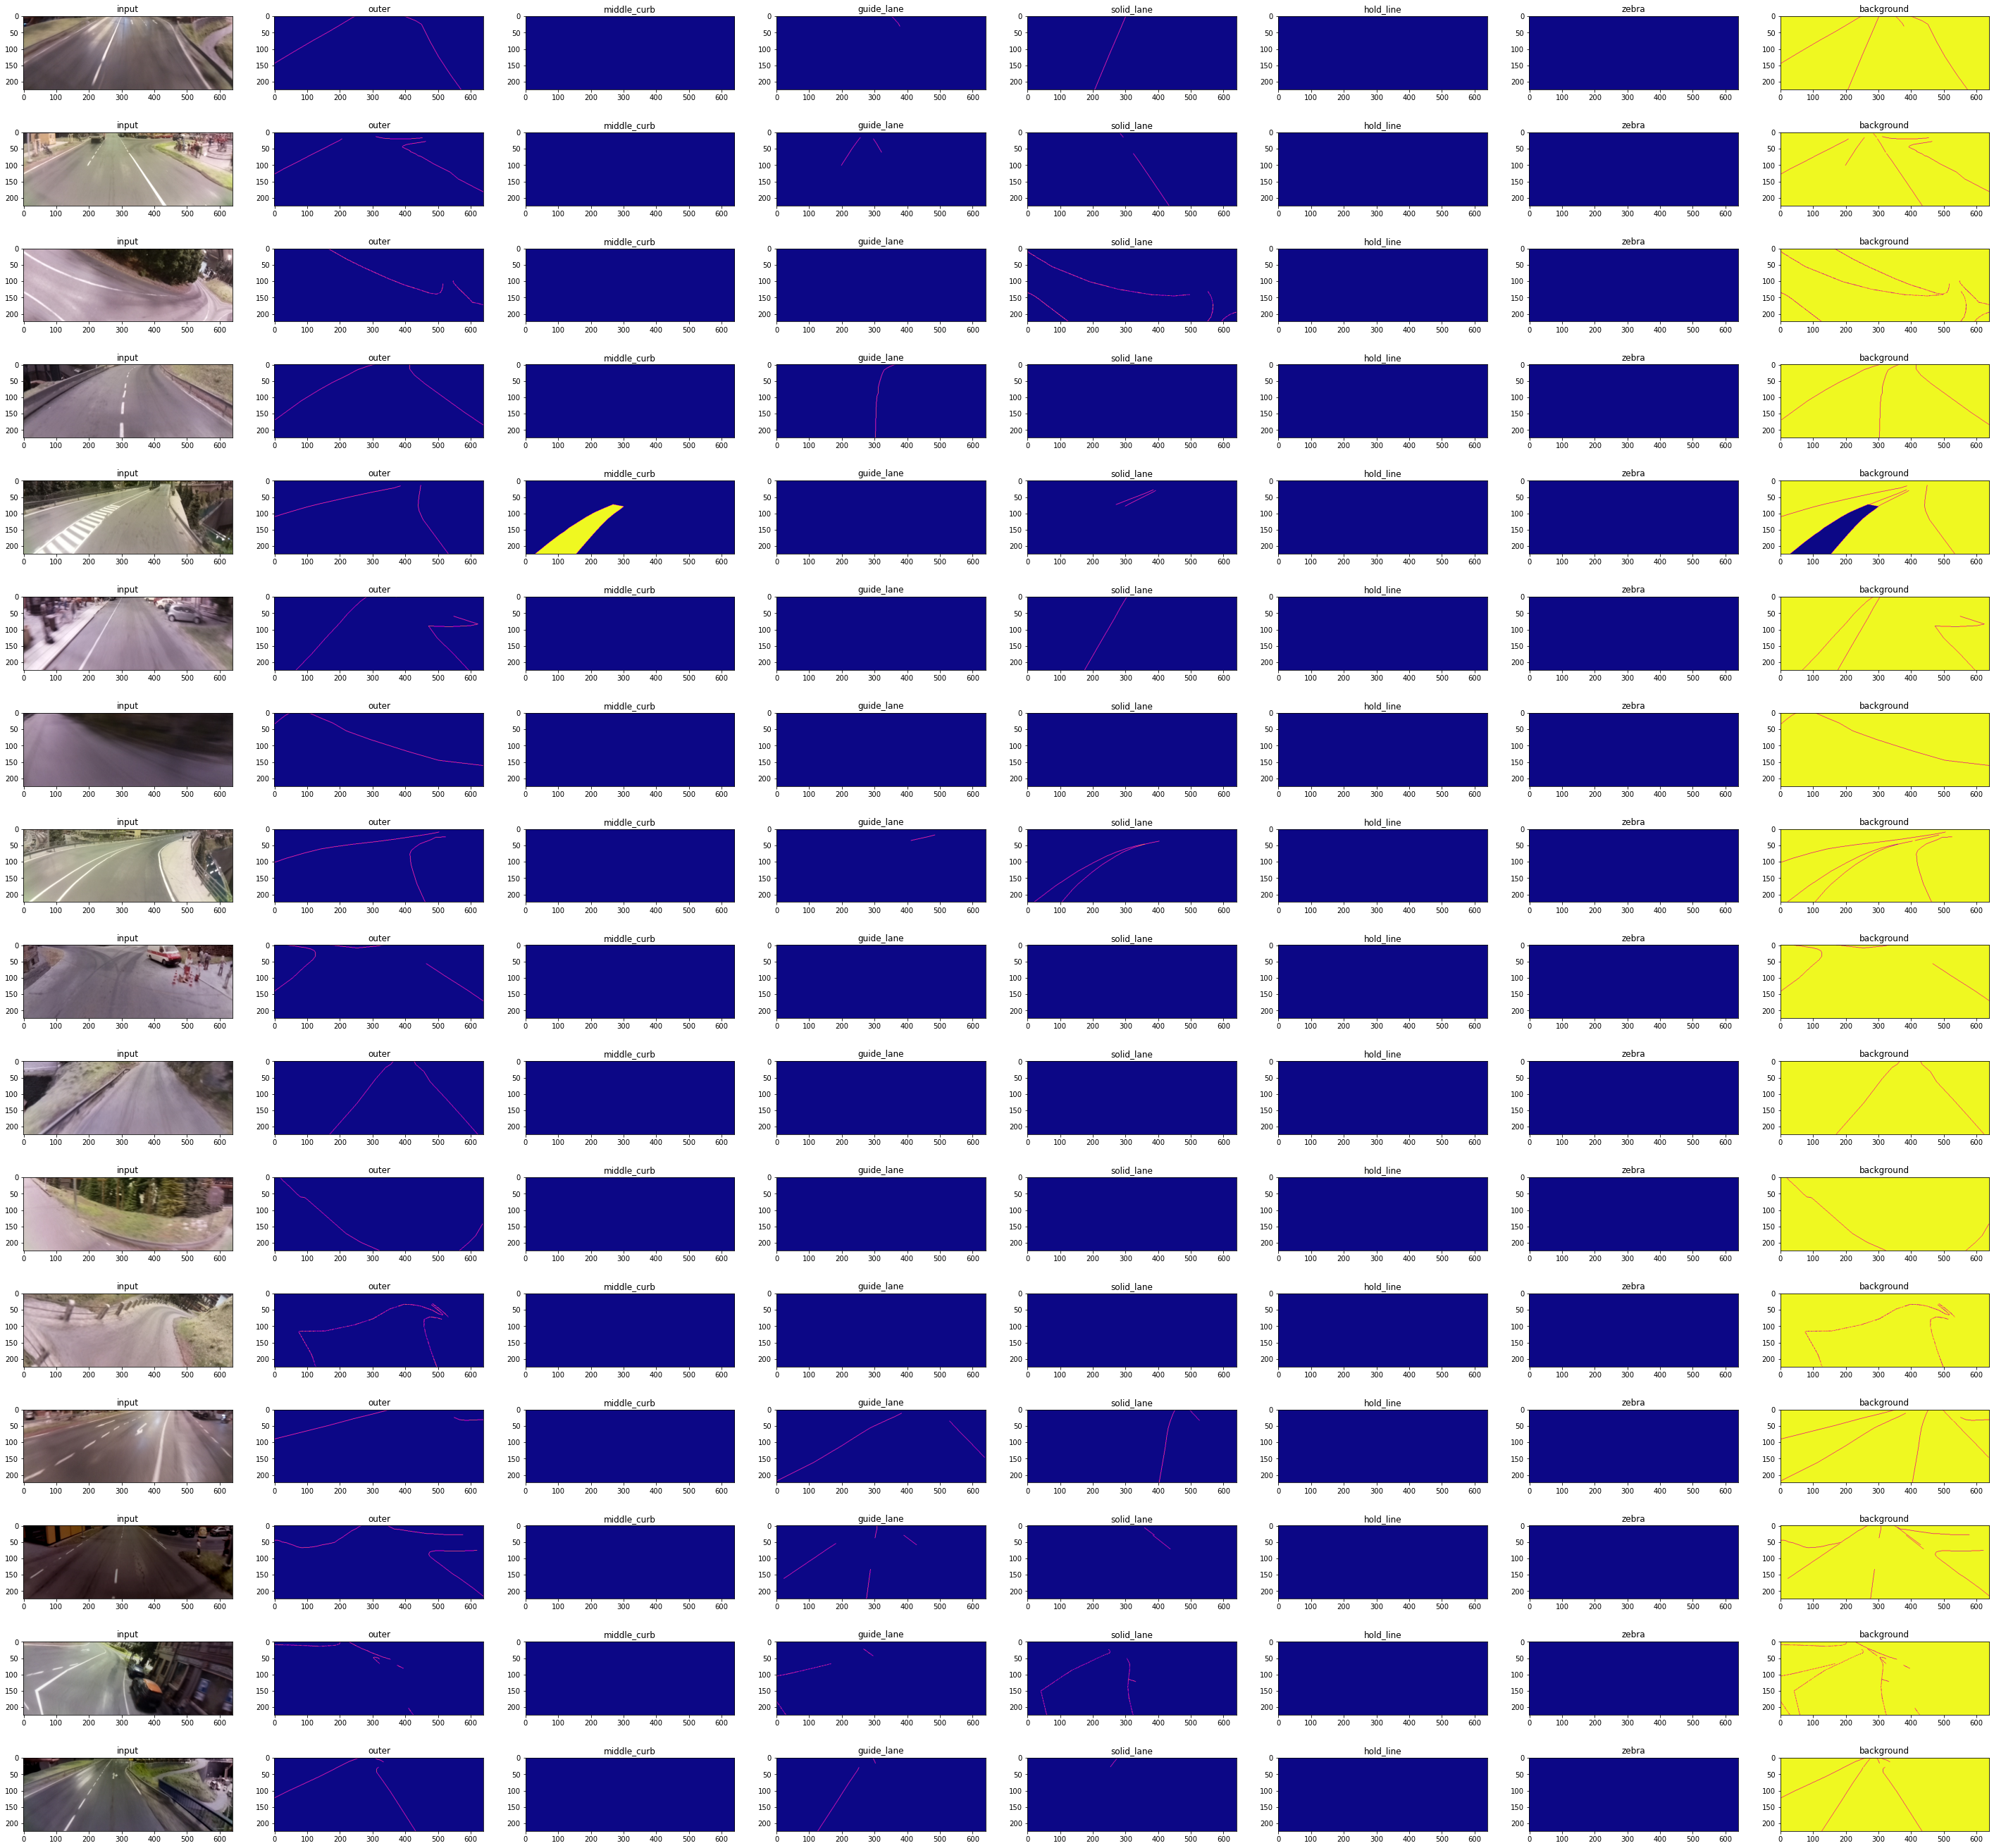

In [12]:
c = 16
f, axs = plt.subplots(c, 8, figsize=(50,c*3))
i = 0

batch_input_test = train_input_img_paths[:c]
batch_target_test = train_target_mask_paths[:c]
images, data = train_gen.data_generation(batch_input_test, batch_target_test)

print(len(images))
for y in range(c):
    axs[y,0].imshow(images[i])
    axs[y,0].title.set_text('input')
    axs[y,1].imshow(data[i][:,:,0], cmap='plasma')
    axs[y,1].title.set_text('outer')
    axs[y,2].imshow(data[i][:,:,1], cmap='plasma')
    axs[y,2].title.set_text('middle_curb')
    axs[y,3].imshow(data[i][:,:,2], cmap='plasma')
    axs[y,3].title.set_text('guide_lane')
    axs[y,4].imshow(data[i][:,:,3], cmap='plasma')
    axs[y,4].title.set_text('solid_lane')
    axs[y,5].imshow(data[i][:,:,4], cmap='plasma')
    axs[y,5].title.set_text('hold_line')
    axs[y,6].imshow(data[i][:,:,5], cmap='plasma')
    axs[y,6].title.set_text('zebra')
    axs[y,7].imshow(data[i][:,:,6], cmap='plasma')
    axs[y,7].title.set_text('background')
    i += 1

In [7]:
import models_backbone as models_b

model = models_b.reference('LANESEGMENTATION_REFERENCE', input_height, input_width, number_classes)
#model = custom_unet()
#model = segmentation_model()

print(model.summary())

Segmentation Models: using `keras` framework.


2021-10-01 10:28:09.789939: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-01 10:28:09.977645: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-01 10:28:09.978235: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-01 10:28:09.980160: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "LANESEGMENTATION_REFERENCE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 640, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 640, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 640, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 320, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 320, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 320, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [ ]:
# checkpoint
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
#config.gpu_options.per_process_gpu_memory_fraction = 0.4
sess = tf.compat.v1.Session(config=config)
    
filepath="./model/ld_autosys_checkpoint.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

tf.get_logger().setLevel('ERROR')

history = model.fit(train_gen,
            validation_data=val_gen,
            epochs=epochs,
            use_multiprocessing=False,
            workers=6,
            callbacks=callbacks_list)
model.save(model_path)

In [ ]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('custom.png')
plt.show()



In [ ]:
# load model only if not trained in this session\
model = load_model('./model/ld_autosys.h5', custom_objects={'iou_score':None})

In [ ]:
# load some test images
cnt = 10

batch_input_test = train_input_img_paths[:cnt]
batch_target_test = train_target_ann_paths[:cnt]
images, data = train_gen.data_generation(batch_input_test, batch_target_test)

In [ ]:
predictions = model.predict(np.array(images))[:cnt]

thres_value = 0.2

def postprocess_channel(img):
    #img = cv2.medianBlur(img, 3)
    _, img = cv2.threshold(img,thres_value,1.0,cv2.THRESH_BINARY)
    return img

f, axs = plt.subplots(len(predictions), 8, figsize=(50,len(predictions)*3))
for i, prediciton in enumerate(predictions):
    #test_img = cv2.resize(test_imgs[i], (x_values, y_values))
    test_img = images[i]
    test_img = test_img.astype(np.float32)
    predicted_lanes = np.sum([postprocess_channel(prediciton[:,:,i]) for i in range(6)], axis=0)
    predicted_lanes = cv2.merge([np.zeros_like(predicted_lanes), np.zeros_like(predicted_lanes), predicted_lanes])
    predicted_lanes = cv2.resize(predicted_lanes, (test_img.shape[1], test_img.shape[0]))
    overlay_image = cv2.addWeighted(test_img, 0.5, predicted_lanes, 0.5, 0)
    axs[i,0].imshow(overlay_image)
    #axs[i,0].imshow(test_imgs[i])

    axs[i,1].imshow(postprocess_channel(prediciton[:,:,0]), cmap='plasma')
    axs[i,1].title.set_text('outer')
    axs[i,2].imshow(postprocess_channel(prediciton[:,:,1]), cmap='plasma')
    axs[i,2].title.set_text('middle_curb')
    axs[i,3].imshow(postprocess_channel(prediciton[:,:,2]), cmap='plasma')
    axs[i,3].title.set_text('guide_lane')
    axs[i,4].imshow(postprocess_channel(prediciton[:,:,3]), cmap='plasma')
    axs[i,4].title.set_text('solid_lane')
    axs[i,5].imshow(postprocess_channel(prediciton[:,:,4]), cmap='plasma')
    axs[i,5].title.set_text('hold_line')
    axs[i,6].imshow(postprocess_channel(prediciton[:,:,5]), cmap='plasma')
    axs[i,6].title.set_text('zebra')
    axs[i,7].imshow(postprocess_channel(prediciton[:,:,6]), cmap='plasma')
    axs[i,7].title.set_text('background')